## DATA PREPARATION

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib
from sklearn.cluster import KMeans


real_df = pd.read_table('/projects/genomic-ml/da2343/ml_project_2/robust_algo_trader/data/EURUSD_H1_200702210000_202304242100.tsv')
# real_df = pd.read_table('/projects/genomic-ml/da2343/ml_project_2/robust_algo_trader/data/EURUSD_H1_202302010000_202304242100.tsv')

df = real_df.copy()
# take only last 7000 rows
df = df.iloc[-(200+24*7*17):]

# remove the following columns <TICKVOL>, <VOL> and <SPREAD>
df = df.drop(['<TICKVOL>', '<VOL>', '<SPREAD>'], axis=1)
df = df.rename(columns={'<DATE>': 'Date', 
                                '<TIME>': 'Time', 
                                '<OPEN>': 'Open', 
                                '<HIGH>': 'High', 
                                '<LOW>': 'Low', 
                                '<CLOSE>': 'Close'
                                })
# combine the date and time columns
df['Date_Time'] = df['Date'] + ' ' + df['Time']
# remove the date and time columns
df = df.drop(['Date', 'Time'], axis=1)
# convert the date_time column to datetime
df['Time'] = pd.to_datetime(df['Date_Time'])
# Rename Date_Time to Time
# df.index = df['Time']
# df.set_index("Time")
# remove the Time column
df = df.drop(['Time'], axis=1)

prices = df["Close"].values
df["SMA"] = talib.SMA(prices, timeperiod=200)
df = df.dropna()

In [66]:
df

,Open,High,Low,Close,Date_Time,SMA
97318,1.00273,1.00277,1.00109,1.00141,2022.11.08 03:00:00,0.991723
97319,1.00140,1.00157,1.00069,1.00078,2022.11.08 04:00:00,0.991689
97320,1.00075,1.00148,1.00064,1.00132,2022.11.08 05:00:00,0.991656
97321,1.00132,1.00144,1.00035,1.00059,2022.11.08 06:00:00,0.991618
97322,1.00059,1.00075,0.99954,0.99957,2022.11.08 07:00:00,0.991575
...,...,...,...,...,...,...
100170,1.10237,1.10370,1.10207,1.10294,2023.04.24 17:00:00,1.098075
100171,1.10294,1.10323,1.10206,1.10260,2023.04.24 18:00:00,1.098125
100172,1.10260,1.10342,1.10249,1.10340,2023.04.24 19:00:00,1.098180
100173,1.10341,1.10484,1.10336,1.10441,2023.04.24 20:00:00,1.098238


## STRATEGY 1: MACD CROSSOVER + KMeans for TP and SL levels

### KMeans clustering for forecasting TP and SL levels

In [46]:

close_df = df[['Close']]

# reshape the data into a 2D array
X = close_df.values.reshape(-1,1)

# choose the number of clusters (you can use other methods to find the optimal number)
k = 10

# create and fit the k means model
model = KMeans(n_clusters=k, random_state=0, n_init = 100, max_iter = 1000)
model.fit(X)

# get the cluster labels and centroids
labels = model.labels_
centroids = model.cluster_centers_

# # assign the labels and centroids to the dataframe
# df['Label'] = labels
# df['Centroid'] = df['Label'].apply(lambda x: centroids[x])

# # plot the data with the clusters and centroids
# plt.figure(figsize=(10,6))
# plt.plot(df['Close'], label='Price')
# # plt.plot(df['Centroid'], label='Centroid')
# plt.scatter(df.index, df['Centroid'], c=df['Label'], cmap='rainbow', marker='o', s=50, alpha=0.5, label='Cluster')
# plt.title(f'Support and Resistance Levels using K-Means Clustering')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.legend()

#### MACD CROSSOVER

In [55]:
# Define MACD parameters
short_ema = 5 # 12
long_ema = 13 #26
signal_ema = 8 #9


# Calculate MACD and signal lines
df["EMA_short"] = df["Close"].ewm(span=short_ema, adjust=False).mean()
df["EMA_long"] = df["Close"].ewm(span=long_ema, adjust=False).mean()

df["MACD"] = df["EMA_short"] - df["EMA_long"]
df["Signal"] = df["MACD"].ewm(span=signal_ema, adjust=False).mean()

# Find MACD crossovers
df["Crossover"] = np.where(df["MACD"] > df["Signal"], 1, -1)
df["Crossover_change"] = df["Crossover"].diff()
df = df.dropna()
df = df.reset_index(drop=True)

#### IMPULSE MACD CROSSOVER

In [67]:
# Define MACD parameters
short_ema = 5 # 12
long_ema = 13 #26
signal_ema = 8 #9

# Calculate MACD and signal lines
df["EMA_short"] = df["Close"].ewm(span=short_ema, adjust=False).mean()
df["EMA_long"] = df["Close"].ewm(span=long_ema, adjust=False).mean()
df["MACD"] = df["EMA_short"] - df["EMA_long"]
df["Signal"] = df["MACD"].ewm(span=signal_ema, adjust=False).mean()

# Calculate high and low moving averages
df["MA_high"] = df["High"].rolling(window=signal_ema).mean()
df["MA_low"] = df["Low"].rolling(window=signal_ema).mean()

# Calculate Impulse MACD and its signal line
df["Impulse_MACD"] = np.where((df["MACD"] > df["MA_low"]) & (df["MACD"] < df["MA_high"]), 0, df["MACD"])
df["Impulse_Signal"] = df["Impulse_MACD"].ewm(span=signal_ema, adjust=False).mean()

# Find Impulse MACD crossovers
df["Crossover"] = np.where(df["Impulse_MACD"] > df["Impulse_Signal"], 1, -1)
df["Crossover_change"] = df["Crossover"].diff()

df = df.dropna()
df = df.reset_index(drop=True)

In [68]:
df

,Open,High,Low,Close,Date_Time,SMA,EMA_short,EMA_long,MACD,Signal,MA_high,MA_low,Impulse_MACD,Impulse_Signal,Crossover,Crossover_change
0,0.99995,1.00055,0.99787,0.99827,2022.11.08 10:00:00,0.991445,0.999559,1.000355,-0.000796,-0.000403,1.001225,0.999804,-0.000796,-0.000403,-1,0.0
1,0.99827,1.00037,0.99717,1.00035,2022.11.08 11:00:00,0.991400,0.999822,1.000354,-0.000532,-0.000432,1.000925,0.999314,-0.000532,-0.000432,-1,0.0
2,1.00036,1.00048,0.99932,0.99950,2022.11.08 12:00:00,0.991358,0.999715,1.000232,-0.000517,-0.000451,1.000789,0.999143,-0.000517,-0.000451,-1,0.0
3,0.99949,1.00099,0.99897,0.99984,2022.11.08 13:00:00,0.991320,0.999757,1.000176,-0.000419,-0.000444,1.000727,0.998934,-0.000419,-0.000444,1,2.0
4,0.99984,1.00017,0.99853,0.99938,2022.11.08 14:00:00,0.991283,0.999631,1.000062,-0.000431,-0.000441,1.000569,0.998706,-0.000431,-0.000441,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845,1.10237,1.10370,1.10207,1.10294,2023.04.24 17:00:00,1.098075,1.101911,1.100547,0.001364,0.000921,1.101834,1.099757,0.001364,0.000921,1,0.0
2846,1.10294,1.10323,1.10206,1.10260,2023.04.24 18:00:00,1.098125,1.102141,1.100840,0.001300,0.001005,1.102384,1.100441,0.001300,0.001005,1,0.0
2847,1.10260,1.10342,1.10249,1.10340,2023.04.24 19:00:00,1.098180,1.102560,1.101206,0.001354,0.001083,1.102693,1.100954,0.001354,0.001083,1,0.0
2848,1.10341,1.10484,1.10336,1.10441,2023.04.24 20:00:00,1.098238,1.103177,1.101664,0.001513,0.001178,1.103041,1.101380,0.001513,0.001178,1,0.0


In [69]:


# Define K-means parameters
n_clusters = 5 # Number of clusters for TP and SL levels
random_state = 0 # Random seed for reproducibility
profit_pips = 0.0050
loss_pips = 0.0100

# Initialize an empty numpy array of dictionaries
orders = np.array([])

# Loop through the rows of the dataframe
for i in range(len(df)):
    # If there is a MACD crossover
    if df.loc[i, "Crossover_change"] != 0:
        # Get the ask price
        ask_price = df.loc[i, "Close"]
        # Get the position (buy or sell)
        position = "Buy" if df.loc[i, "Crossover_change"] == 2 else "Sell"
        ## Get the next n rows of price data
        # next_prices = df.loc[i+1:i+n_clusters, "Close"].values.reshape(-1, 1)
        # Fit K-means on the next prices
        # kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init='auto').fit(next_prices)
        # Get the cluster centers as the TP and SL levels
        # tp_sl_levels = kmeans.cluster_centers_.flatten()
        # Sort the levels in ascending order
        # tp_sl_levels.sort()
      
        if position == "Buy":
            tp_level = ask_price + profit_pips
            sl_level = ask_price - loss_pips
        else:
            tp_level = ask_price - profit_pips
            sl_level = ask_price + loss_pips   
        

        
        # tp_level = tp_sl_levels[-1] if position == "Buy" else tp_sl_levels[0]
        # sl_level = tp_sl_levels[0] if position == "Buy" else tp_sl_levels[-1]
        # Calculate the TP and SL ratios
        tp_ratio = abs(tp_level - ask_price) / ask_price
        sl_ratio = abs(sl_level - ask_price) / ask_price
        # Check if the TP ratio is greater than the SL ratio
        # Create a dictionary with the order details
        order = {
                     "ask_price": ask_price,
                     "take_profit_price": tp_level,
                     "stop_loss_price": sl_level,
                     "position": position,
        }
        # Append the dictionary to the numpy array
        orders = np.append(orders, order)

# Print the numpy array of dictionaries
# print(orders)


In [70]:
len(orders)

363

## Testing the performance of the strategy

In [71]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

# Load price data
# Initialize an empty list to store the trade outcomes
outcomes = []
test_period = 99976 

update_orders = np.array([])

# Loop through the orders array
for order in orders:
    # Get the order details
    ask_price = order["ask_price"]
    tp_price = order["take_profit_price"]
    sl_price = order["stop_loss_price"]
    position = order["position"]
    # Find the index of the row where the ask price matches the close price in the dataframe
    index = df.index[df["Close"] == ask_price][0]
    # Get the next n rows of price data from the close column of the dataframe, where n is equal to the number of clusters
    next_prices = df.loc[index+1:index+test_period, "Close"].values
    # Initialize a variable to store the trade outcome
    outcome = None
    # Loop through the next prices
    for price in next_prices:
        # If the position is buy, check if the price reaches the TP or SL level
        if position == "Buy":
            # If the price is greater than or equal to the TP level, set the outcome to 1 and break the loop
            if price >= tp_price:
                outcome = 1
                update_orders = np.append(update_orders, order)
                break
            # If the price is less than or equal to the SL level, set the outcome to 0 and break the loop
            elif price <= sl_price:
                outcome = 0
                break
        # If the position is sell, check if the price reaches the TP or SL level
        elif position == "Sell":
            # If the price is less than or equal to the TP level, set the outcome to 1 and break the loop
            if price <= tp_price:
                outcome = 1
                update_orders = np.append(update_orders, order)
                break
            # If the price is greater than or equal to the SL level, set the outcome to 0 and break the loop
            elif price >= sl_price:
                outcome = 0
                break
    # Append the outcome to the outcomes list
    outcomes.append(outcome)

# Convert the outcomes list to a numpy array
# remove None values from outcomes
filtered_outcomes = [x for x in outcomes if x is not None]

pred_y = np.array(filtered_outcomes)

test_y = [1]*len(pred_y)
accuracy = accuracy_score(test_y, pred_y)
print(f"Accuracy: {accuracy}")


Accuracy: 0.7098591549295775


In [ ]:
Accuracy: 0.6439736468156569
Accuracy: 0.6439276485788114

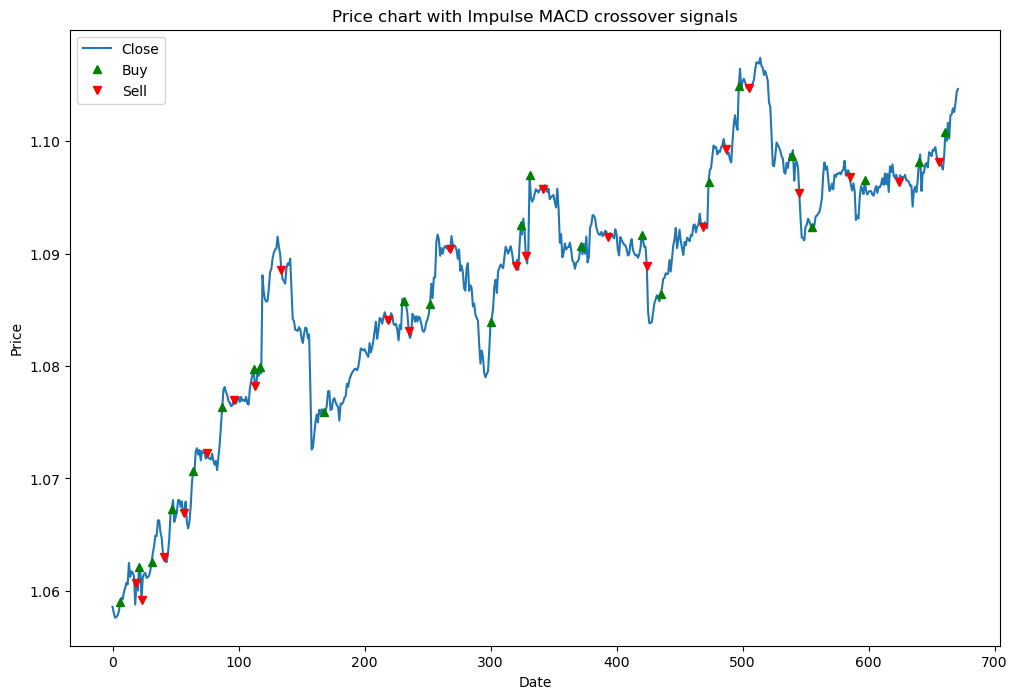

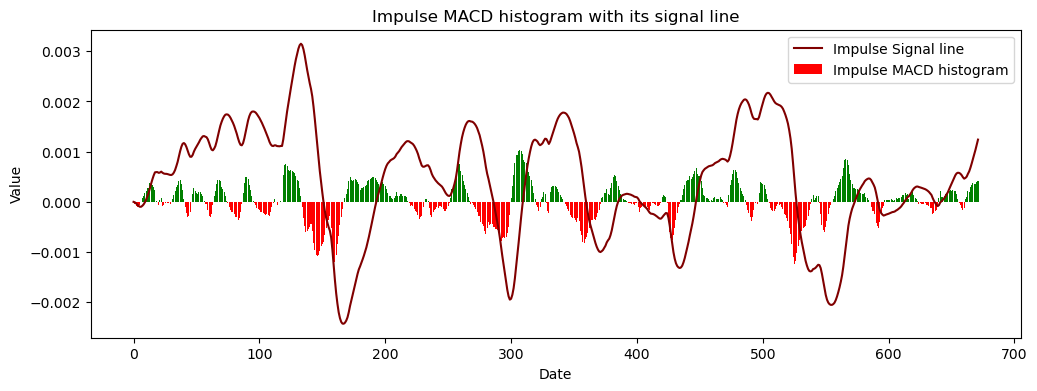

In [13]:


# Define buy and sell signals
buy_signal = df[df["Crossover_change"] == 2]
sell_signal = df[df["Crossover_change"] == -2]

# Plot the price chart with Impulse MACD and its signal line
plt.figure(figsize=(12,8))
plt.plot(df["Close"], label="Close")
plt.plot(buy_signal["Close"], marker="^", color="green", linestyle="None", label="Buy")
plt.plot(sell_signal["Close"], marker="v", color="red", linestyle="None", label="Sell")
plt.legend()
plt.title("Price chart with Impulse MACD crossover signals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

# Plot the Impulse MACD histogram with its signal line
plt.figure(figsize=(12,4))
plt.bar(df.index, df["Impulse_MACD"] - df["Impulse_Signal"], color=df["Crossover"].map({1:"green", -1:"red"}), label="Impulse MACD histogram")
plt.plot(df["Impulse_Signal"], color="maroon", label="Impulse Signal line")
plt.legend()
plt.title("Impulse MACD histogram with its signal line")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()
